In [1]:
import sys
import os
sys.path.append("/home/smets/codes/far/PHARE/pyphare/")
import pyphare
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
import numpy as np
%matplotlib widget

In [2]:
run_path = "/DATA/phare/harris/tiny"
os.listdir(run_path)

['EM_B.h5',
 'EM_E.h5',
 'harris-688134.log',
 'harris.py',
 'ions_bulkVelocity.h5',
 'ions_density.h5',
 'ions_pop_protons_density.h5',
 'ions_pop_protons_domain.h5',
 'ions_pop_protons_flux.h5',
 'job.sh']

In [3]:
run  = Run(run_path)
time = 10.0

In [4]:
part_hier = run.GetParticles(0.0, "protons")

In [5]:
# method de run.py
from pyphare.pharesee.hierarchy import FieldData
import pyphare.core.box as mbox
from pyphare.core.gridlayout import GridLayout
from scipy.stats import binned_statistic_2d

def _compute_cross_correlation(patch):
    domain_pop_name = list(patch.patch_datas.keys())[0]
    dset = patch.patch_datas[domain_pop_name].dataset

    nbG = GridLayout().nbrGhosts(interpOrder = 1, centering = "dual")
    ghost_ = [nbG, nbG]# nbrGhost

    #the v_i.v_j correlation tensors have to be defined on a ghost box
    xx = np.zeros(mbox.grow(patch.box, ghost_).shape)
    xy = np.zeros(mbox.grow(patch.box, ghost_).shape)
    xz = np.zeros(mbox.grow(patch.box, ghost_).shape)
    yy = np.zeros(mbox.grow(patch.box, ghost_).shape)
    yz = np.zeros(mbox.grow(patch.box, ghost_).shape)
    zz = np.zeros(mbox.grow(patch.box, ghost_).shape)

    i_ = dset.iCells[:, 0]
    j_ = dset.iCells[:, 1]

    #Pxx = FieldData(patch.layout, "Pxx", xx, centering=["primal"]*patch.box.ndim)

    # this is a 0th order interpolation : we could do better
    b = mbox.grow(patch.box, ghost_)
    binx = np.arange(b.lower[0], b.upper[0]+1)
    biny = np.arange(b.lower[1], b.upper[1]+1)

    xx = binned_statistic_2d(i_,j_,dset.weights[:,0]*dset.v[:, 0]*dset.v[:, 0], statistic='sum', bins=[binx, biny]).statistic
    xy = binned_statistic_2d(i_,j_,dset.weights[:,0]*dset.v[:, 0]*dset.v[:, 1], statistic='sum', bins=[binx, biny]).statistic
    xz = binned_statistic_2d(i_,j_,dset.weights[:,0]*dset.v[:, 0]*dset.v[:, 2], statistic='sum', bins=[binx, biny]).statistic
    yy = binned_statistic_2d(i_,j_,dset.weights[:,0]*dset.v[:, 1]*dset.v[:, 1], statistic='sum', bins=[binx, biny]).statistic
    yz = binned_statistic_2d(i_,j_,dset.weights[:,0]*dset.v[:, 1]*dset.v[:, 2], statistic='sum', bins=[binx, biny]).statistic
    zz = binned_statistic_2d(i_,j_,dset.weights[:,0]*dset.v[:, 2]*dset.v[:, 2], statistic='sum', bins=[binx, biny]).statistic

    return ({"name":"Pxx", "data":xx, "centering":["dual"]*patch.box.ndim},
            {"name":"Pxy", "data":xy, "centering":["dual"]*patch.box.ndim},
            {"name":"Pxz", "data":xz, "centering":["dual"]*patch.box.ndim},
            {"name":"Pyy", "data":yy, "centering":["dual"]*patch.box.ndim},
            {"name":"Pyz", "data":yz, "centering":["dual"]*patch.box.ndim},
            {"name":"Pzz", "data":zz, "centering":["dual"]*patch.box.ndim})

In [6]:
from pyphare.pharesee.hierarchy import compute_hier_from

def GetP(time, pop_name, kind='total', base='xyz', save=False):
    if isinstance(pop_name, (list, tuple)):
        assert len(pop_name) == 1
    else:
        assert isinstance(pop_name, str)

    P = compute_hier_from(run.GetParticles(time, pop_name), _compute_cross_correlation)
    mass = run.GetMass(pop_name) # will be substituted by self..GetMass(pop_name) in run.py
    for ilvl, lvl in P.levels(time).items():
        for patch in lvl.patches:
            pdata_xx = patch.patch_datas['Pxx']
            pdata_xy = patch.patch_datas['Pxy']
            pdata_xz = patch.patch_datas['Pxz']
            pdata_yy = patch.patch_datas['Pyy']
            pdata_yz = patch.patch_datas['Pyz']
            pdata_zz = patch.patch_datas['Pzz']

            pdata_xx.dataset = mass*pdata_xx.dataset
            pdata_xy.dataset = mass*pdata_xy.dataset
            pdata_xz.dataset = mass*pdata_xz.dataset
            pdata_yy.dataset = mass*pdata_yy.dataset
            pdata_yz.dataset = mass*pdata_yz.dataset
            pdata_zz.dataset = mass*pdata_zz.dataset

    if kind == 'total':
        pass

    if save == True:
        pass

    if base == 'aligned':
        pass

    return P

In [7]:
P = GetP(time, "protons")

In [8]:
print(P.levels(time)[0].patches[0].patch_datas['Pxx'].dataset)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.1979732  ... 0.21857428 0.19636876 0.        ]
 ...
 [0.         0.         0.21560008 ... 0.21357096 0.19847502 0.        ]
 [0.         0.         0.21209774 ... 0.17235701 0.19092684 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [9]:
print(P.patch_levels[0].patches[0].box)
print(P.patch_levels[0].patches[0].patch_datas)
print(P.patch_levels[0].patches[1].patch_datas["Pxx"].dataset[:])

Box([0, 0],[44, 44])
{'Pxx': FieldData: (box=(Box([0, 0],[44, 44]), [45 45]), key=Pxx), 'Pxy': FieldData: (box=(Box([0, 0],[44, 44]), [45 45]), key=Pxy), 'Pxz': FieldData: (box=(Box([0, 0],[44, 44]), [45 45]), key=Pxz), 'Pyy': FieldData: (box=(Box([0, 0],[44, 44]), [45 45]), key=Pyy), 'Pyz': FieldData: (box=(Box([0, 0],[44, 44]), [45 45]), key=Pyz), 'Pzz': FieldData: (box=(Box([0, 0],[44, 44]), [45 45]), key=Pzz)}
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.18578224 ... 0.1982792  0.19876562 0.        ]
 ...
 [0.         0.         0.21883596 ... 0.18921641 0.17052949 0.        ]
 [0.         0.         0.19475897 ... 0.21597231 0.19438548 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x', ylabel='y'>)

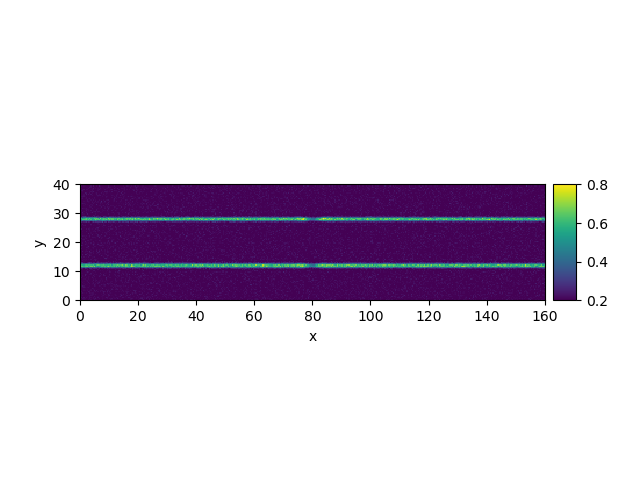

In [10]:
P.plot(qty='Pxx',
      vmin=0.2,
      vmax=0.8,
      cmap='viridis')

In [ ]:
# Junk ?
def GetParticles(time, pop_name, hier=None):
    #def filename(name):
    #    return f"ions_pop_{name}_domain.h5"
    filename = lambda name : f"ions_pop_{name}_domain.h5"
    if isinstance(pop_name, (list, tuple)):
        for pop in pop_name:
            hier = run._get_hierarchy(time, filename(pop), hier=hier)
        return hier
    return run._get_hierarchy(time, filename(pop_name), hier=hier)